# Evaluación del tiempo de atención a incidentes viales

Se trabajó con el dataset "" que contiene los datos de los reportes de incidentes viales de la ciudad de México de los años 2016 a 2021 realizados por el c4. Este dataset fue preprocesdado durante el módulo anterior. 

In [1]:
# Importar librearías

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt
from scipy import stats as sts

In [2]:
df = pd.read_csv('data/incidentes-viales-c5-limpio.csv', sep="$", index_col=0)
df.head()

,folio,codigo_cierre,delegacion_inicio,incidente_c4,latitud,longitud,clas_con_f_alarma,tipo_entrada,delegacion_cierre,mes,fecha_hora_cierre,fecha_hora_creacion
2,C5/170622/03715,(N) La unidad de atención a emergencias fue de...,VENUSTIANO CARRANZA,accidente-choque sin lesionados,19.43053,-99.05260,EMERGENCIA,LLAMADA DEL 911,VENUSTIANO CARRANZA,6,2017-06-22 16:48:07,2017-06-22 13:44:52
5,C5/170621/07339,(A) La unidad de atención a emergencias fue de...,IZTAPALAPA,accidente-choque sin lesionados,19.38676,-99.03350,EMERGENCIA,LLAMADA DEL 911,IZTAPALAPA,6,2017-06-22 03:53:51,2017-06-21 23:29:01
8,C5/170622/01694,(N) La unidad de atención a emergencias fue de...,IZTAPALAPA,accidente-choque sin lesionados,19.35017,-99.07324,EMERGENCIA,LLAMADA DEL 911,IZTAPALAPA,6,2017-06-22 10:47:19,2017-06-22 08:51:30
9,C5/170622/03779,(N) La unidad de atención a emergencias fue de...,CUAJIMALPA,accidente-choque sin lesionados,19.37273,-99.27753,EMERGENCIA,LLAMADA DEL 911,CUAJIMALPA,6,2017-06-22 14:17:46,2017-06-22 13:49:44
12,C5/170622/04693,(N) La unidad de atención a emergencias fue de...,MIGUEL HIDALGO,accidente-choque sin lesionados,19.45316,-99.19868,EMERGENCIA,LLAMADA DEL 911,MIGUEL HIDALGO,6,2017-06-22 16:47:41,2017-06-22 15:48:39


In [3]:
df.shape

(369280, 12)

In [6]:
diccionario_de_conversion = {
    'codigo_cierre': 'category',
    'fecha_hora_creacion': 'datetime64[ns]',
    'fecha_hora_cierre': 'datetime64[ns]', 
    'delegacion_inicio': 'category',
    'incidente_c4': 'category', 
    'clas_con_f_alarma': 'category', 
    'tipo_entrada': 'category',
    'delegacion_cierre':'category',
    'mes':'category'
}
df = df.astype(diccionario_de_conversion)

In [7]:
df.describe()

,latitud,longitud
count,369280.000000,369280.000000
mean,19.382307,-99.137894
std,0.069267,0.062467
min,19.095427,-99.370561
25%,19.335590,-99.180590
50%,19.383290,-99.141057
75%,19.433160,-99.096370
max,19.579320,-98.945370


# 1. Tiempo de Atención

Se creó la columna "tiempo_atencion" que contiene el tiempo en horas (decimal) que transcurrió entre la creación del reporte y su cierre. 

In [8]:
df['tiempo_atencion'] = (df['fecha_hora_cierre'] - df['fecha_hora_creacion']) / dt.timedelta(hours=1)
df.head()

,folio,codigo_cierre,delegacion_inicio,incidente_c4,latitud,longitud,clas_con_f_alarma,tipo_entrada,delegacion_cierre,mes,fecha_hora_cierre,fecha_hora_creacion,tiempo_atencion
2,C5/170622/03715,(N) La unidad de atención a emergencias fue de...,VENUSTIANO CARRANZA,accidente-choque sin lesionados,19.43053,-99.05260,EMERGENCIA,LLAMADA DEL 911,VENUSTIANO CARRANZA,6,2017-06-22 16:48:07,2017-06-22 13:44:52,3.054167
5,C5/170621/07339,(A) La unidad de atención a emergencias fue de...,IZTAPALAPA,accidente-choque sin lesionados,19.38676,-99.03350,EMERGENCIA,LLAMADA DEL 911,IZTAPALAPA,6,2017-06-22 03:53:51,2017-06-21 23:29:01,4.413889
8,C5/170622/01694,(N) La unidad de atención a emergencias fue de...,IZTAPALAPA,accidente-choque sin lesionados,19.35017,-99.07324,EMERGENCIA,LLAMADA DEL 911,IZTAPALAPA,6,2017-06-22 10:47:19,2017-06-22 08:51:30,1.930278
9,C5/170622/03779,(N) La unidad de atención a emergencias fue de...,CUAJIMALPA,accidente-choque sin lesionados,19.37273,-99.27753,EMERGENCIA,LLAMADA DEL 911,CUAJIMALPA,6,2017-06-22 14:17:46,2017-06-22 13:49:44,0.467222
12,C5/170622/04693,(N) La unidad de atención a emergencias fue de...,MIGUEL HIDALGO,accidente-choque sin lesionados,19.45316,-99.19868,EMERGENCIA,LLAMADA DEL 911,MIGUEL HIDALGO,6,2017-06-22 16:47:41,2017-06-22 15:48:39,0.983889


## 1.1. Limpieza

Se encontrarón valores de tiempo de atención negativos. Lo cuál es evidentemente un error, puesto que significaría que el reporte de incidente fue cerrado antes de que se creara. 

In [10]:
df_backup = df.copy()
print(f"Hay {df[df['tiempo_atencion'] < 0].shape[0]} datos con tiempo de atención negativo")

Hay 1922 datos con tiempo de atención negativo


In [12]:
wrong_data = df.copy()
wrong_data = wrong_data[wrong_data['tiempo_atencion']<0]
wrong_data[['fecha_hora_cierre', 'fecha_hora_creacion', 'tiempo_atencion']]

,fecha_hora_cierre,fecha_hora_creacion,tiempo_atencion
1558,2017-01-07 01:16:27,2017-06-30 21:20:01,-4196.059444
1572,2017-01-07 07:30:12,2017-06-30 21:50:57,-4190.345833
1583,2017-01-07 00:21:41,2017-06-30 22:04:54,-4197.720278
1586,2017-01-07 00:30:19,2017-06-30 22:50:41,-4198.339444
1596,2017-01-07 04:41:22,2017-06-30 22:12:23,-4193.516944
...,...,...,...
685919,2021-02-13 03:02:14,2021-12-02 23:50:32,-7028.805000
685920,2021-02-13 03:02:03,2021-12-02 23:57:47,-7028.928889
685921,2021-02-13 00:11:33,2021-12-02 21:07:37,-7028.934444
685922,2021-02-13 00:29:36,2021-12-02 22:23:19,-7029.895278


Estos datos aparecen porque para ciertos valores de las columnas "fecha_hora_cierre" y "fecha_hora_creación" no se respeta el formato "AAAA-MM-DD" provocando ambigüedad en las fechas reportadas. Por ejemplo, el reporte con índice 1558
dice haber sido levantado el día 30 de junio del 2017 pero su fecha de cierre es 07 de enero del 2017 (una fecha anterior), sin embargo, al invertir el mes y día de la fecha de cierre, sería 01 de julio del 2017, lo cual hace más sentido. 

Para resolverlo, se corrigen las fechas mal escritas en la columna "fecha_hora_creacion":

In [13]:
# Condicion 1, Día y mes de creación invertidos en fecha_hora_creacion
c1 = (wrong_data.fecha_hora_cierre.dt.day >= 12) & (wrong_data.fecha_hora_cierre.dt.month == wrong_data.fecha_hora_creacion.dt.day)
wd_c1 = wrong_data[c1]
wd_c1[['fecha_hora_cierre', 'fecha_hora_creacion', 'tiempo_atencion']]

,fecha_hora_cierre,fecha_hora_creacion,tiempo_atencion
2389,2017-06-13 00:40:18,2017-12-06 22:39:42,-4245.990000
2394,2017-06-13 06:02:22,2017-12-06 23:24:58,-4241.376667
2450,2017-06-13 02:00:42,2017-12-06 23:37:22,-4245.611111
2480,2017-06-13 04:15:43,2017-12-06 21:34:35,-4241.314444
2503,2017-06-13 02:20:30,2017-12-06 23:24:30,-4245.066667
...,...,...,...
685919,2021-02-13 03:02:14,2021-12-02 23:50:32,-7028.805000
685920,2021-02-13 03:02:03,2021-12-02 23:57:47,-7028.928889
685921,2021-02-13 00:11:33,2021-12-02 21:07:37,-7028.934444
685922,2021-02-13 00:29:36,2021-12-02 22:23:19,-7029.895278


In [14]:
# 982 de 1922 datos
wd_c1['fecha_hora_creacion'] = wd_c1['fecha_hora_creacion'].apply(lambda x: dt.datetime.strftime(x, '%Y-%d-%m %H:%M:%S'))
wd_c1['fecha_hora_creacion'] = pd.to_datetime(wd_c1['fecha_hora_creacion'])
wd_c1['tiempo_atencion'] = (wd_c1['fecha_hora_cierre'] - wd_c1['fecha_hora_creacion']) / dt.timedelta(hours=1)
df.loc[wd_c1.index] = wd_c1
df.loc[wd_c1.index][['fecha_hora_cierre', 'fecha_hora_creacion', 'tiempo_atencion']]

<ipython-input-14-6692366cff53>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wd_c1['fecha_hora_creacion'] = wd_c1['fecha_hora_creacion'].apply(lambda x: dt.datetime.strftime(x, '%Y-%d-%m %H:%M:%S'))
<ipython-input-14-6692366cff53>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wd_c1['fecha_hora_creacion'] = pd.to_datetime(wd_c1['fecha_hora_creacion'])
<ipython-input-14-6692366cff53>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

,fecha_hora_cierre,fecha_hora_creacion,tiempo_atencion
2389,2017-06-13 00:40:18,2017-06-12 22:39:42,2.010000
2394,2017-06-13 06:02:22,2017-06-12 23:24:58,6.623333
2450,2017-06-13 02:00:42,2017-06-12 23:37:22,2.388889
2480,2017-06-13 04:15:43,2017-06-12 21:34:35,6.685556
2503,2017-06-13 02:20:30,2017-06-12 23:24:30,2.933333
...,...,...,...
685919,2021-02-13 03:02:14,2021-02-12 23:50:32,3.195000
685920,2021-02-13 03:02:03,2021-02-12 23:57:47,3.071111
685921,2021-02-13 00:11:33,2021-02-12 21:07:37,3.065556
685922,2021-02-13 00:29:36,2021-02-12 22:23:19,2.104722


A continuacion las fechas de cierre mal escritas que se abrieron en un mes y se cerraron al siguiente

In [15]:
# Correction of 'fecha_hora_cierre' en la frontera superior del mes
c3 = (wrong_data.fecha_hora_creacion.dt.day >= 12) & (wrong_data.fecha_hora_creacion.dt.month == wrong_data.fecha_hora_cierre.dt.day-1)
wd_c3 = wrong_data[c3]
wd_c3[['fecha_hora_cierre', 'fecha_hora_creacion', 'tiempo_atencion']]

,fecha_hora_cierre,fecha_hora_creacion,tiempo_atencion
1558,2017-01-07 01:16:27,2017-06-30 21:20:01,-4196.059444
1572,2017-01-07 07:30:12,2017-06-30 21:50:57,-4190.345833
1583,2017-01-07 00:21:41,2017-06-30 22:04:54,-4197.720278
1586,2017-01-07 00:30:19,2017-06-30 22:50:41,-4198.339444
1596,2017-01-07 04:41:22,2017-06-30 22:12:23,-4193.516944
...,...,...,...
680767,2021-01-02 00:16:24,2021-01-31 23:09:56,-718.892222
680769,2021-01-02 00:02:56,2021-01-31 23:20:38,-719.295000
680770,2021-01-02 02:21:40,2021-01-31 23:30:34,-717.148333
680771,2021-01-02 05:05:36,2021-01-31 23:37:20,-714.528889


In [17]:
# 933 de 1922
wd_c3['fecha_hora_cierre'] = wd_c3['fecha_hora_cierre'].apply(lambda x: dt.datetime.strftime(x, '%Y-%d-%m %H:%M:%S'))
wd_c3['fecha_hora_cierre'] = pd.to_datetime(wd_c3['fecha_hora_cierre'])
wd_c3['tiempo_atencion'] = (wd_c3['fecha_hora_cierre'] - wd_c3['fecha_hora_creacion']) / dt.timedelta(hours=1)
df.loc[wd_c3.index] = wd_c3
df.loc[wd_c3.index][['fecha_hora_cierre', 'fecha_hora_creacion', 'tiempo_atencion']]

<ipython-input-17-228895b02313>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wd_c3['fecha_hora_cierre'] = wd_c3['fecha_hora_cierre'].apply(lambda x: dt.datetime.strftime(x, '%Y-%d-%m %H:%M:%S'))
<ipython-input-17-228895b02313>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wd_c3['fecha_hora_cierre'] = pd.to_datetime(wd_c3['fecha_hora_cierre'])
<ipython-input-17-228895b02313>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

,fecha_hora_cierre,fecha_hora_creacion,tiempo_atencion
1558,2017-07-01 01:16:27,2017-06-30 21:20:01,3.940556
1572,2017-07-01 07:30:12,2017-06-30 21:50:57,9.654167
1583,2017-07-01 00:21:41,2017-06-30 22:04:54,2.279722
1586,2017-07-01 00:30:19,2017-06-30 22:50:41,1.660556
1596,2017-07-01 04:41:22,2017-06-30 22:12:23,6.483056
...,...,...,...
680767,2021-02-01 00:16:24,2021-01-31 23:09:56,1.107778
680769,2021-02-01 00:02:56,2021-01-31 23:20:38,0.705000
680770,2021-02-01 02:21:40,2021-01-31 23:30:34,2.851667
680771,2021-02-01 05:05:36,2021-01-31 23:37:20,5.471111


A continuación las fechas de creacion mal escritas que se abrieron en un mes y se cerraron al siguiente

In [18]:
c4 = (wrong_data.fecha_hora_cierre.dt.day >= 12) & (wrong_data.fecha_hora_cierre.dt.month == wrong_data.fecha_hora_creacion.dt.day+1)
wd_c4 = wrong_data[c4]
wd_c4[['fecha_hora_cierre', 'fecha_hora_creacion', 'tiempo_atencion']]

,fecha_hora_cierre,fecha_hora_creacion,tiempo_atencion
543375,2019-06-24 03:29:33,2019-07-05 12:32:30,-273.049167
545762,2019-07-24 21:31:44,2019-11-06 18:17:38,-2516.765000


In [19]:
wd_c4['fecha_hora_creacion'] = wd_c4['fecha_hora_creacion'].apply(lambda x: dt.datetime.strftime(x, '%Y-%d-%m %H:%M:%S'))
wd_c4['fecha_hora_creacion'] = pd.to_datetime(wd_c4['fecha_hora_creacion'])
wd_c4['tiempo_atencion'] = (wd_c4['fecha_hora_cierre'] - wd_c4['fecha_hora_creacion']) / dt.timedelta(hours=1)
df.loc[wd_c4.index] = wd_c4
df.loc[wd_c4.index][['fecha_hora_cierre', 'fecha_hora_creacion', 'tiempo_atencion']]

<ipython-input-19-81bde7204589>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wd_c4['fecha_hora_creacion'] = wd_c4['fecha_hora_creacion'].apply(lambda x: dt.datetime.strftime(x, '%Y-%d-%m %H:%M:%S'))
<ipython-input-19-81bde7204589>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wd_c4['fecha_hora_creacion'] = pd.to_datetime(wd_c4['fecha_hora_creacion'])
<ipython-input-19-81bde7204589>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

,fecha_hora_cierre,fecha_hora_creacion,tiempo_atencion
543375,2019-06-24 03:29:33,2019-05-07 12:32:30,1142.950833
545762,2019-07-24 21:31:44,2019-06-11 18:17:38,1035.235000


El resto de valores negativos es ambiguo, pues ambas fechas podrían estar escritas correctamente por lo que no podemos determinar con certeza cual fecha hay que corregir. Por lo tanto se deshecharan estos datos.

In [20]:
df[df['tiempo_atencion'] < 0][['fecha_hora_cierre', 'fecha_hora_creacion', 'tiempo_atencion']]

,fecha_hora_cierre,fecha_hora_creacion,tiempo_atencion
32410,2017-02-12 02:02:15,2017-06-11 18:36:34,-2872.571944
105387,2017-03-04 04:09:41,2017-09-03 16:11:26,-4404.029167
487063,2019-03-09 22:56:42,2019-05-08 20:08:13,-1437.191944
488133,2019-09-09 17:20:59,2019-10-08 08:08:36,-686.793611
512716,2019-09-09 17:54:24,2019-12-08 17:32:25,-2159.633611


In [21]:
df_clean = df[df['tiempo_atencion'] > 0]
df_clean_backup = df_clean.copy()
df_clean.head()

,folio,codigo_cierre,delegacion_inicio,incidente_c4,latitud,longitud,clas_con_f_alarma,tipo_entrada,delegacion_cierre,mes,fecha_hora_cierre,fecha_hora_creacion,tiempo_atencion
2,C5/170622/03715,(N) La unidad de atención a emergencias fue de...,VENUSTIANO CARRANZA,accidente-choque sin lesionados,19.43053,-99.05260,EMERGENCIA,LLAMADA DEL 911,VENUSTIANO CARRANZA,6,2017-06-22 16:48:07,2017-06-22 13:44:52,3.054167
5,C5/170621/07339,(A) La unidad de atención a emergencias fue de...,IZTAPALAPA,accidente-choque sin lesionados,19.38676,-99.03350,EMERGENCIA,LLAMADA DEL 911,IZTAPALAPA,6,2017-06-22 03:53:51,2017-06-21 23:29:01,4.413889
8,C5/170622/01694,(N) La unidad de atención a emergencias fue de...,IZTAPALAPA,accidente-choque sin lesionados,19.35017,-99.07324,EMERGENCIA,LLAMADA DEL 911,IZTAPALAPA,6,2017-06-22 10:47:19,2017-06-22 08:51:30,1.930278
9,C5/170622/03779,(N) La unidad de atención a emergencias fue de...,CUAJIMALPA,accidente-choque sin lesionados,19.37273,-99.27753,EMERGENCIA,LLAMADA DEL 911,CUAJIMALPA,6,2017-06-22 14:17:46,2017-06-22 13:49:44,0.467222
12,C5/170622/04693,(N) La unidad de atención a emergencias fue de...,MIGUEL HIDALGO,accidente-choque sin lesionados,19.45316,-99.19868,EMERGENCIA,LLAMADA DEL 911,MIGUEL HIDALGO,6,2017-06-22 16:47:41,2017-06-22 15:48:39,0.983889


## 1.2 Estimados de locación y variabilidad 

In [24]:
tiempo_atencion_mean = df_clean.tiempo_atencion.mean()
tiempo_atencion_std = df_clean.tiempo_atencion.std()
tiempo_atencion_median = df_clean.tiempo_atencion.median()
tiempo_atencion_trimmed_mean = sts.trim_mean(df_clean['tiempo_atencion'], 0.01)

print(f'La media del tiempo de atención es {round(tiempo_atencion_mean,2)} horas')
print(f'La varianza del tiempo de atención es {round(tiempo_atencion_std,2)} horas')
print(f'La mediana del tiempo de atención es {round(tiempo_atencion_mean,2)} horas')
print(f'La media del tiempo de atención es {round(tiempo_atencion_trimmed_mean,2)} horas')

La media del tiempo de atención es 22.73 horas
La varianza del tiempo de atención es 132.22 horas
La mediana del tiempo de atención es 22.73 horas
La media del tiempo de atención es 15.16 horas


Como la media y la mediana son muy parecidas, es probable que no haya valores atípicos. Esto es reforzado por el hecho de qe la media truncada al 1% cambia mucho en comparación a la media. Sin embargo, revisaremos los estimados de orden para corroborarlo 

## 1.3 Estimados de orden

In [25]:
tiempo_atencion_min = df_clean['tiempo_atencion'].min()
tiempo_atencion_percentile_10 = df_clean['tiempo_atencion'].quantile(0.1)
tiempo_atencion_percentile_25 = df_clean['tiempo_atencion'].quantile(0.25)
tiempo_atencion_percentile_50 = df_clean['tiempo_atencion'].quantile(0.5)
tiempo_atencion_percentile_75 = df_clean['tiempo_atencion'].quantile(0.75)
tiempo_atencion_percentile_90 = df_clean['tiempo_atencion'].quantile(0.9)
tiempo_atencion_max = df_clean['tiempo_atencion'].max()

print(f'El valor tiempo de atención mínimo es de {round(tiempo_atencion_min,2)} horas')
print(f'El percentil 10% de tiempo de atención es {round(tiempo_atencion_percentile_10,2)} horas')
print(f'El percentil 25% de tiempo de atención es {round(tiempo_atencion_percentile_25,2)} horas')
print(f'El percentil 50% de tiempo de atención es {round(tiempo_atencion_percentile_50,2)} horas')
print(f'El percentil 75% de tiempo de atención es {round(tiempo_atencion_percentile_75,2)} horas')
print(f'El percentil 90% de tiempo de atención es {round(tiempo_atencion_percentile_90,2)} horas')
print(f'El valor tiempo de atención máximo es de {round(tiempo_atencion_max,2)} horas')

El valor tiempo de atención mínimo es de 0.0 horas
El percentil 10% de tiempo de atención es 0.25 horas
El percentil 25% de tiempo de atención es 0.45 horas
El percentil 50% de tiempo de atención es 1.05 horas
El percentil 75% de tiempo de atención es 2.37 horas
El percentil 90% de tiempo de atención es 4.62 horas
El valor tiempo de atención máximo es de 16501.44 horas


La diferencia tan grande entre el tiempo de atención máximo y el percentil 90 demuestran que efectivamente hay valores atípicos que pueden ser encontrados

In [26]:
tiempo_atencion_range = tiempo_atencion_max - tiempo_atencion_min 
tiempo_atencion_iq_range = tiempo_atencion_percentile_75 - tiempo_atencion_percentile_25

In [27]:
print(f'El rango del tiempo de atencion es {round(tiempo_atencion_range,2)} horas')
print(f'El rango intercuartil del tiempo de atencion es {round(tiempo_atencion_iq_range,2)} horas')

El rango del tiempo de atencion es 16501.43 horas
El rango intercuartil del tiempo de atencion es 1.92 horas


In [28]:
df_clean.describe()

,latitud,longitud,tiempo_atencion
count,369275.000000,369275.000000,369275.000000
mean,19.382308,-99.137894,22.727953
std,0.069267,0.062468,132.217097
min,19.095427,-99.370561,0.004722
25%,19.335590,-99.180590,0.447222
50%,19.383290,-99.141057,1.047222
75%,19.433160,-99.096370,2.368611
max,19.579320,-98.945370,16501.436111


In [29]:
sns.set(style="ticks")
ta = df_clean['tiempo_atencion']

[Text(0, 0.5, 'Densidad'), Text(0.5, 0, 'Tiempo atención (Horas)')]

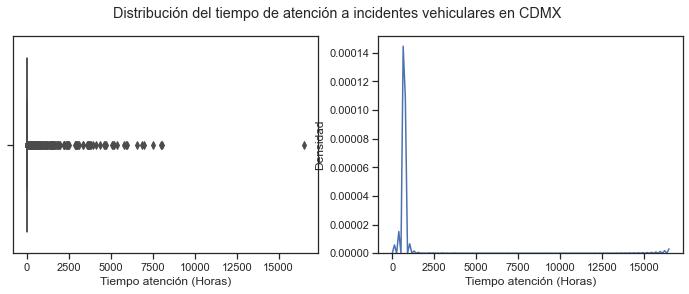

In [31]:
fig, axs = plt.subplots(1, 2, sharey=False, sharex=False, figsize=(12,4))

fig.suptitle('Distribución del tiempo de atención a incidentes vehiculares en CDMX')

# Boxplot
sns.boxplot(x=ta, ax=axs[0]);
axs[0].set(xlabel='Tiempo atención (Horas)')

# Desnity plot
sns.distplot(ta, hist=False, ax=axs[1]);
axs[1].set(xlabel='Tiempo atención (Horas)', ylabel='Densidad')

## 1.4 Filtro de datos atípicos

Se filtraron los datos utilizando el rango intercuartílico como parámetro para filtrar los datos atípicos.

In [32]:
ll = ta > tiempo_atencion_percentile_25 - (tiempo_atencion_iq_range * 1.5)
ul = ta < tiempo_atencion_percentile_75 + (tiempo_atencion_iq_range * 1.5)

df_filtered = df_clean[ll & ul]
ta_filtered = df_filtered['tiempo_atencion']

In [33]:
# Porcentaje de datos eliminados por ser atípicos
(1 - (ta_filtered.shape[0]/ta.shape[0]))*100

8.223952339042718

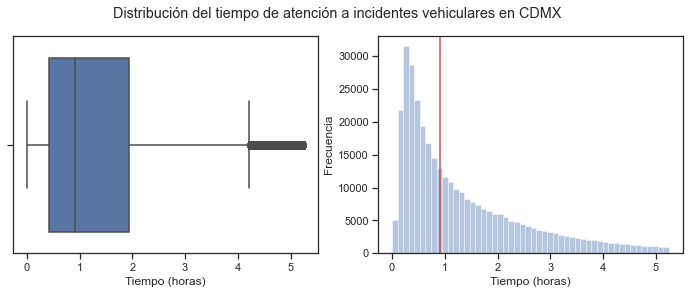

In [125]:
fig, axs = plt.subplots(1, 2, sharey=False, sharex=False, figsize=(12,4))

fig.suptitle('Distribución del tiempo de atención a incidentes vehiculares en CDMX')

# Boxplot
sns.boxplot(x=ta_filtered, ax=axs[0]);
axs[0].set(xlabel='Tiempo (horas)');

# Desnity plot
sns.distplot(ta_filtered, kde=False, norm_hist=False, bins=50, ax=axs[1]);
axs[1].set(xlabel='Tiempo (horas)');
axs[1].set(ylabel='Frecuencia');
axs[1].axvline(ta_filtered.median(), color='r')

plt.savefig('img/ta_distribucion.png')

In [35]:
df_filtered.describe()

,latitud,longitud,tiempo_atencion
count,338906.000000,338906.000000,338906.000000
mean,19.381929,-99.138307,1.334218
std,0.069209,0.062472,1.181696
min,19.095427,-99.370561,0.004722
25%,19.335170,-99.180690,0.416389
50%,19.383070,-99.141370,0.912917
75%,19.432550,-99.096880,1.932500
max,19.579320,-98.945370,5.250556


Esta nueva información sigue una distribución más concentrada considerando únicamente los tiempos de atención que representan al grueso de los datos.

# 2. Análisis exploratorio del tiempo de atención

In [36]:
from scipy.stats import skew, kurtosis

print(f'Curtosis: {kurtosis(ta_filtered)}')
print(f'Asimetría: {skew(ta_filtered)}')

Curtosis: 0.8476598876103325
Asimetría: 1.2497437625678218


Tal como se aprecia en la gráfica de densidad, el tiempo de atención a los incidentes viales tiene una distribución asimétrica cargada a la izquierda con un coeficiente de asimetría mayor a 1.2. La curtosis resultó ser mayor a 0.84, esto implica que hay más dispersión de los datos. 

## 2.3. Distribución por categorías

### Delegación

Se realizó un análisis exploratorio de la distribución del tiempo de atención por localidades, para ver si hay delegaciones en donde los incidentes reportados se cierran con mayor prontitud.

In [130]:
by_delegacion = df_filtered.groupby('folio')[['tiempo_atencion', 'latitud', 'longitud']].last()
delegacion = df.groupby('folio')['delegacion_inicio'].last()
merged = by_delegacion.merge(delegacion, left_index=True, right_index=True)
by_delegacion.head()

,tiempo_atencion,latitud,longitud
folio,,,
AO/161231/06182,3.967778,19.305150,-99.234510
AO/170101/00965,0.837778,19.402387,-99.231725
AO/170101/01450,1.065833,19.322567,-99.247142
AO/170101/02807,3.210833,19.349600,-99.304640
AO/170102/03200,2.970000,19.389630,-99.194224


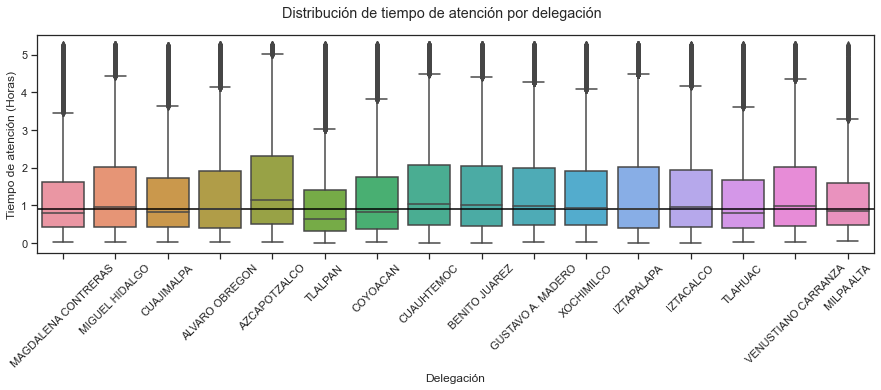

In [132]:
plt.figure(figsize=(15, 4))
sns.boxplot(data=merged, x='delegacion_inicio', y='tiempo_atencion');
plt.suptitle('Distribución de tiempo de atención por delegación');
plt.xticks(rotation=45);
plt.xlabel('Delegación');
plt.ylabel('Tiempo de atención (Horas)');
plt.axhline(ta_filtered.median(), color='#000000');

plt.savefig('img/ta_distribucion_delegacion.png')

Se observó que las medianas del tiempo de atención por delegación oscilan al rededor de la media muestral original, y no difieren demasiado entre ellas. 

### Clase de incidente 

El c4 clasifica los reportes en 4 clases dependiendo de la gravedad de la situación, las cuales son:
* Emergencias
* Urgencias médicas
* Delitos
* Flasas alarmas

El análisis exploratorio por clase se realizó para ver si este grado de emergencia influye directamente en el tiempo de atencion. 

In [134]:
by_clase = df_filtered.groupby('folio')[['tiempo_atencion', 'latitud', 'longitud']].last()
clase = df.groupby('folio')['clas_con_f_alarma'].last()
merged = by_clase.merge(clase, left_index=True, right_index=True)

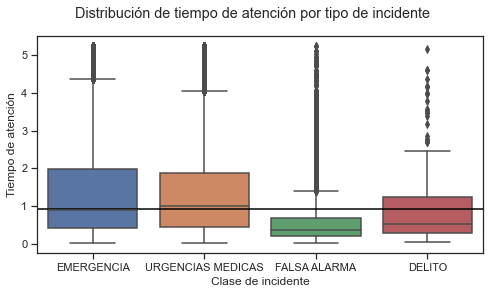

In [135]:
plt.figure(figsize=(8, 4))
sns.boxplot(data=merged, x='clas_con_f_alarma', y='tiempo_atencion');
plt.suptitle('Distribución de tiempo de atención por tipo de incidente');
plt.xlabel('Clase de incidente');
plt.ylabel('Tiempo de atención');
plt.axhline(ta_filtered.median(), color='#000000');

plt.savefig('img/ta_distribucion_clase.png')

Se observó que el tiempo de atención para emergencias, urgencias y delitos es bastante cercano a la media muestral original. Sin embargo, las falsas alarmas son cerradas con mucha mayor prontitud. Lo anterior tiene sentido, ya que normalmente las falsas alarmas se detectan incluso antes de enviar unidades al sitio, o se identifican rápidamente estando ahí. 

### Características del incidente

Las características del incicente clasifican los siniestros dependiendo de claves particulares que identifican la magnitud del accidente y el estado de los involucrados.

In [137]:
by_incidente = df_filtered.groupby('folio')[['tiempo_atencion', 'latitud', 'longitud']].last()
clase = df.groupby('folio')['incidente_c4'].last()
merged = by_clase.merge(clase, left_index=True, right_index=True)

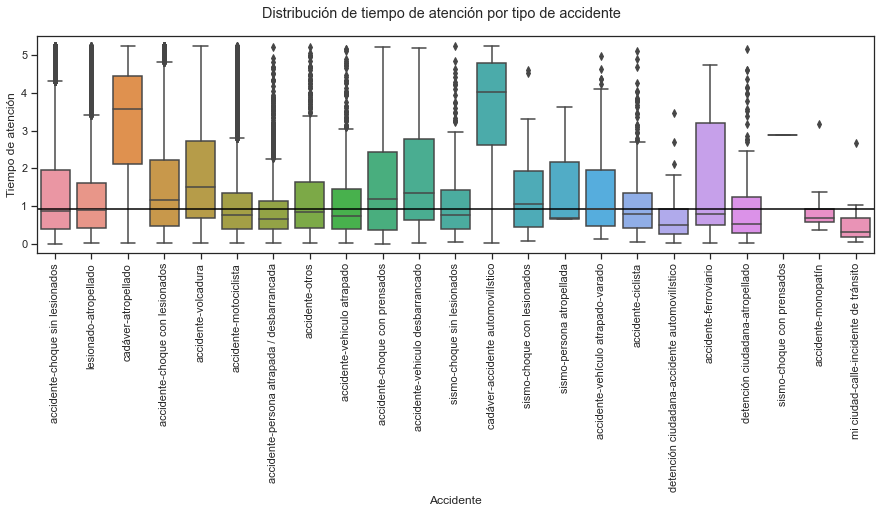

In [138]:
plt.figure(figsize=(15, 4))
sns.boxplot(data=merged, x='incidente_c4', y='tiempo_atencion');
plt.suptitle('Distribución de tiempo de atención por tipo de accidente');
plt.xticks(rotation=90);
plt.xlabel('Accidente');
plt.ylabel('Tiempo de atención');
plt.axhline(ta_filtered.median(), color='#000000');

plt.savefig('img/ta_distribucion_tipo.png')

Se encontró mayor variabilidad en cuanto al tiempo de atención entre los diferentes tipos de incidentes, así como una gran dispersión entre ellos. Dentro de la información más notable se puede observar que los incidentes que involucran cádaveres (por atropellamiento o colision entre vehiculos) suelen tardar mucho más en resolverse que la media general.Por otro lado los incidentes que involucran lesionados suelen tener mayoy variabilidad y outliers.

### Entrada del reporte

Actualmente el c4 utiliza 8 herramientas de entrada para que civiles o autoridades viales levanten reportes de incidentes, las cuáles son:
* Radio
* Botón de auxilio
* Cámara
* Llamada del 911
* Redes sociales
* Aplicacion 911
* Aplicación Zello
* Aplicativos

In [139]:
by_entrada = df_filtered.groupby('folio')[['tiempo_atencion', 'latitud', 'longitud']].last()
entrada = df.groupby('folio')['tipo_entrada'].last()
merged = by_clase.merge(entrada, left_index=True, right_index=True)

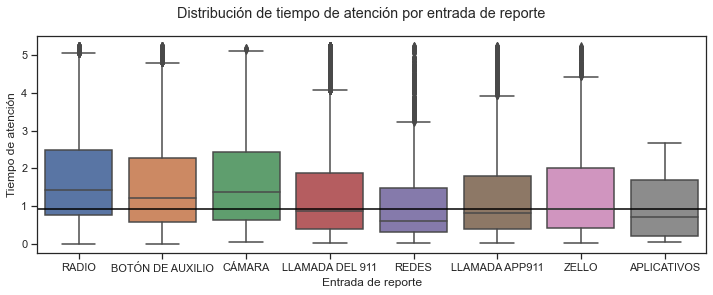

In [140]:
plt.figure(figsize=(12, 4))
sns.boxplot(data=merged, x='tipo_entrada', y='tiempo_atencion');
plt.suptitle('Distribución de tiempo de atención por entrada de reporte');
plt.xlabel('Entrada de reporte');
plt.ylabel('Tiempo de atención');
plt.axhline(ta_filtered.median(), color='#000000');

plt.savefig('img/ta_distribucion_entrada.png')

# 3. Preguntas

A partir de éste análisis exploratorio se encontraron algunas preguntas interesantes que podrían resolverse.

* **¿Es realmente diferente el tiempo de atención entre delegaciones, tipos de incidentes, o medios de reporte?**
* **¿El uso de aplicaciones móviles tiene un impacto en el tiempo de atención a los reportes?**
* **En caso de tenerlo, ¿Es más eficiente que el reporte por métodos tradicionales como la llamada?**
* **¿Existe una relación entre los factores antes mencionados que influya sobre el tiempo de atención?**

Resolver estas interrogantes justificaría el desarrollo de un modelo que permita predecir los tiempos de atencion de un determinado accidente, o la probabilidad de que dicha llamada sea una falsa alarma. Estos modelos podrían ser de utilidad para evaluar el rendimiento de la autoridades competentes al resolver estos siniestros, así como la eficacia de nuevas propuestas que se tomen en la busqueda de disminuir el tiempo de atención a los reportes.

Para resolver adecuadamente estas preguntas se realizó una segunda limpieza del dataset que consistió en trabajar con un dataset que no hiciera distinción entre el tipo de aplicación utilizada (Zello, APP911, Aplicativos)

In [84]:
df_filtered_bckup = df_filtered.copy()
df_filtered.tipo_entrada = df_filtered.apply(lambda r: 'APLICATIVOS' if (r.tipo_entrada == 'ZELLO') | (r.tipo_entrada == 'LLAMADA APP911') else r.tipo_entrada, axis=1)

## 4. Visualización cruzada

### Tiempo de atencion por delegación y por clase

In [85]:
by_delegacion_clase = df_filtered.groupby(['delegacion_inicio','clas_con_f_alarma'])[['tiempo_atencion']].median()
by_delegacion_clase = by_delegacion_clase.unstack(1)

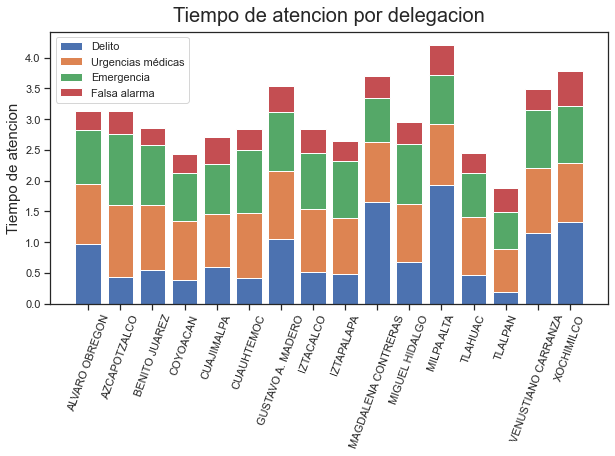

In [141]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()

plt1 = ax.bar(by_delegacion_clase.index, by_delegacion_clase['tiempo_atencion']['DELITO'], 
              #yerr= tiempo_atencion_iq_range,
              label='DELITO')
              #color=["#7788AA","#4E638E","#2E4372","#152A55"])
    
plt2 = ax.bar(by_delegacion_clase.index, by_delegacion_clase['tiempo_atencion']['URGENCIAS MEDICAS'], 
              bottom=by_delegacion_clase['tiempo_atencion']['DELITO']
             )
              #color=["#7788AA","#4E638E","#2E4372","#152A55"])
    
plt3 = ax.bar(by_delegacion_clase.index, by_delegacion_clase['tiempo_atencion']['EMERGENCIA'],
              bottom=by_delegacion_clase['tiempo_atencion']['DELITO']+by_delegacion_clase['tiempo_atencion']['URGENCIAS MEDICAS'],
              label='EMERGENCIA')
              #color=["#FFD0AA", "#D4996A", "#AA6B39", "#804415"])

plt4 = ax.bar(by_delegacion_clase.index, by_delegacion_clase['tiempo_atencion']['FALSA ALARMA'], 
              bottom=by_delegacion_clase['tiempo_atencion']['EMERGENCIA']+by_delegacion_clase['tiempo_atencion']['DELITO']+by_delegacion_clase['tiempo_atencion']['URGENCIAS MEDICAS'])
              #color=["#7788AA","#4E638E","#2E4372","#152A55"])

ax.set_ylabel('Tiempo de atencion', fontsize=15);
ax.set_xlabel('');
plt.xticks(rotation=70);
plt.legend((plt1[0], plt2[0], plt3[0], plt4[0]), ('Delito', 'Urgencias médicas', 'Emergencia', 'Falsa alarma'))
ax.set_title('Tiempo de atencion por delegacion', fontsize=20, pad=10);

plt.savefig('img/ta_delegacion_clase.png')

### Tiempo de atención por delegación y entrada

In [87]:
by_delegacion_entrada = df_filtered.groupby(['delegacion_inicio','tipo_entrada'])[['tiempo_atencion']].median()
by_delegacion_entrada = by_delegacion_entrada.unstack(1)

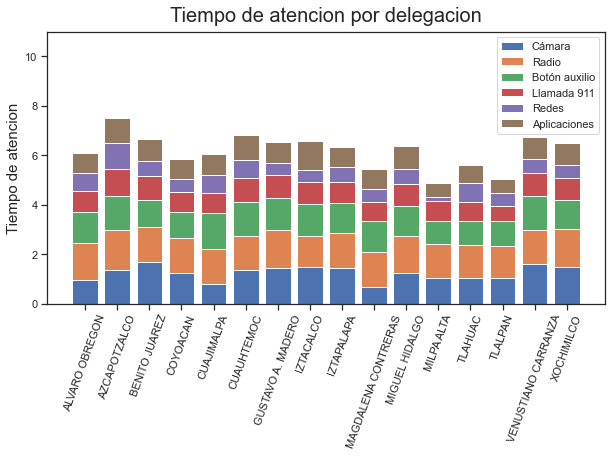

In [142]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()

plt1 = ax.bar(by_delegacion_entrada.index, by_delegacion_entrada['tiempo_atencion']['CÁMARA'], 
              label='CÁMARA')

plt2 = ax.bar(by_delegacion_entrada.index, by_delegacion_entrada['tiempo_atencion']['RADIO'],
              bottom=by_delegacion_entrada['tiempo_atencion']['CÁMARA']
              )

plt3 = ax.bar(by_delegacion_entrada.index, by_delegacion_entrada['tiempo_atencion']['BOTÓN DE AUXILIO'], 
              bottom=by_delegacion_entrada['tiempo_atencion']['CÁMARA']+by_delegacion_entrada['tiempo_atencion']['RADIO']
             )
    
plt4 = ax.bar(by_delegacion_entrada.index, by_delegacion_entrada['tiempo_atencion']['LLAMADA DEL 911'], 
              bottom=by_delegacion_entrada['tiempo_atencion']['CÁMARA']+by_delegacion_entrada['tiempo_atencion']['BOTÓN DE AUXILIO']+by_delegacion_entrada['tiempo_atencion']['RADIO']
             )

plt5 = ax.bar(by_delegacion_entrada.index, by_delegacion_entrada['tiempo_atencion']['REDES'],
              bottom=by_delegacion_entrada['tiempo_atencion']['CÁMARA']+by_delegacion_entrada['tiempo_atencion']['BOTÓN DE AUXILIO']+by_delegacion_entrada['tiempo_atencion']['LLAMADA DEL 911']+by_delegacion_entrada['tiempo_atencion']['RADIO']
              )

plt6 = ax.bar(by_delegacion_entrada.index, by_delegacion_entrada['tiempo_atencion']['APLICATIVOS'],
              bottom=by_delegacion_entrada['tiempo_atencion']['CÁMARA']+by_delegacion_entrada['tiempo_atencion']['BOTÓN DE AUXILIO']+by_delegacion_entrada['tiempo_atencion']['LLAMADA DEL 911']+by_delegacion_entrada['tiempo_atencion']['RADIO']+by_delegacion_entrada['tiempo_atencion']['REDES']
              )
             
ax.set_ylabel('Tiempo de atencion', fontsize=15);
ax.set_ylim(0, 11)
ax.set_xlabel('');
plt.xticks(rotation=70);
plt.legend((plt1[0], plt2[0], plt3[0], plt4[0], plt5[0], plt6[0]), ('Cámara', 'Radio', 'Botón auxilio', 'Llamada 911', 'Redes', 'Aplicaciones'))
ax.set_title('Tiempo de atencion por delegacion', fontsize=20, pad=10);

plt.savefig('img/ta_delegacion_entrada.png')

# 5. A/B test sobre el uso de aplicaciones móviles para reportar incidentes viales

El uso de aplicativos para levantar reportes es una medida implementada recién a partir del 2017.

In [93]:
df_filtered[df_filtered.tipo_entrada == 'APLICATIVOS']['fecha_hora_creacion'].min().year

2017

Se evaluó si el uso de aplicaciones móviles optimiza el timepo de atencion a los incidentes en comparacion a los métodos convencionles (Llamada, cámara, radio o botón) utilizando la información registrada a partir del 2017. Se excluyeron arbitrariamente los reportes realizados mediante redes sociales pues no pertenencen a las categorías de interés.

In [94]:
df_2017 = df_filtered[df_filtered.fecha_hora_creacion.dt.year > 2016][['delegacion_inicio', 'tipo_entrada', 'tiempo_atencion']]
df_2017 = df_2017[df_2017.tipo_entrada != 'REDES']
df_2017.head()

,delegacion_inicio,tipo_entrada,tiempo_atencion
2,VENUSTIANO CARRANZA,LLAMADA DEL 911,3.054167
5,IZTAPALAPA,LLAMADA DEL 911,4.413889
8,IZTAPALAPA,LLAMADA DEL 911,1.930278
9,CUAJIMALPA,LLAMADA DEL 911,0.467222
12,MIGUEL HIDALGO,LLAMADA DEL 911,0.983889


Para este test se consideran dos formas de reporte distintos y se registra la media del tiempo de atención para cada una de ellas. El test A es la hipótesis alternativa (los reportes hechos por aplicativos), mientras que el test B es la hipótesis nula (los reportes levantados por métodos convencionales).

In [122]:
df_ab = df_2017.copy()
df_ab['tipo_entrada_ab'] = df_ab.apply(lambda x: 'APLICATIVOS' if x['tipo_entrada'] == 'APLICATIVOS' else 'OTROS', axis=1)

In [123]:
df_test = df_ab.groupby('tipo_entrada_ab')['tiempo_atencion'].median()
df_test = pd.DataFrame(df_test)
df_test['velocidad_atencion'] = 1 / df_test['tiempo_atencion']
df_test

,tiempo_atencion,velocidad_atencion
tipo_entrada_ab,,
APLICATIVOS,0.851944,1.173785
OTROS,0.916667,1.090909


En la tabla anterior parece que la mediana del timepo de atención es menor cuando el reporte se hizo mediante aplicativos en comparación a los métodos tradicionales. Es decir, que el test A es más veloz para resolver los incidentes que el test B

In [124]:
diferencia = (1 - (df_test.loc['OTROS']['velocidad_atencion'] / df_test.loc['APLICATIVOS']['velocidad_atencion']))*100
print(f'El tiempo de atencion en el test A (aplicativos) fue {round(diferencia,2)}% más rápido que el control')

El tiempo de atencion en el test A (aplicativos) fue 7.06% más rápido que el control


Se aplica un test de permutación para ver si el resultado es producto del azar

In [112]:
df_all = df_ab[['delegacion_inicio', 'tiempo_atencion']] # Eliminar tipo de entrada
value_counts = df_ab['tipo_entrada_ab'].value_counts()

In [113]:
ta_a = []
ta_b = []

for _ in range(1000):
    a = df.sample(value_counts.loc['APLICATIVOS'], replace=False)
    ta_a.append(a['tiempo_atencion'].median())
    
    b = df_ab.loc[~df_ab.index.isin(a.index)]
    ta_b.append(b['tiempo_atencion'].median())

In [117]:
perm_results = pd.DataFrame({
    'ta_APLICATIVOS': ta_a,
    'ta_OTROS': ta_b
})

perm_results['va_APLICATIVOS'] = 1 / perm_results['ta_APLICATIVOS']
perm_results['va_OTROS'] = 1 / perm_results['ta_OTROS']
perm_results['diff'] = 1 - (perm_results.va_OTROS / perm_results.va_APLICATIVOS)
perm_results

,ta_APLICATIVOS,ta_OTROS,va_APLICATIVOS,va_OTROS,diff
0,1.054861,0.915278,0.947992,1.092564,-0.152504
1,1.042083,0.915278,0.959616,1.092564,-0.138543
2,1.045278,0.915278,0.956683,1.092564,-0.142033
3,1.069306,0.915000,0.935186,1.092896,-0.168640
4,1.074444,0.915000,0.930714,1.092896,-0.174256
...,...,...,...,...,...
995,1.055556,0.915278,0.947368,1.092564,-0.153263
996,1.033611,0.915278,0.967482,1.092564,-0.129287
997,1.045139,0.915556,0.956811,1.092233,-0.141535
998,1.048194,0.915278,0.954021,1.092564,-0.145220


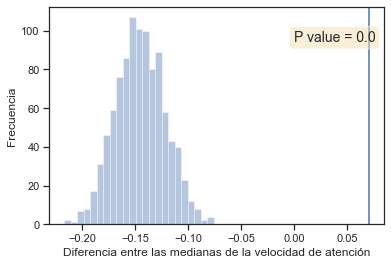

In [143]:
P = (perm_results['diff'] >= diferencia/100).sum() / perm_results.shape[0]
sns.distplot(perm_results['diff'], kde=False, norm_hist=False);
plt.axvline(diferencia/100);
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5);
plt.text(0, 100, f'P value = {P}', fontsize=14, verticalalignment='top', bbox=props);
plt.xlabel('Diferencia entre las medianas de la velocidad de atención');
plt.ylabel('Frecuencia')

plt.savefig('img/ta_test_ab.png')

Esto quiere decir que ninguno de las diferencias obtenidas aleatoreamente es más extrema que la calculada originalmente. Es decir que el valor proporcionado por los datos originales es atípico para ser un valor causado por el azar y por tanto es estadísticamente significativo. Con un p<0.1 rechazamos la  hipótesis nula.